In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. EDA

In [192]:
# Load Data
train_path = './data/train.csv'
test_path = './data/test.csv'
sub_path = './data/gender_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

print(df_train.isnull().sum())
print("======================")
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [193]:
# 'Age', 'Cabin', 'Embarked', 'Fare' colums has NaN
# In 'Age','Fare' NaN is mean for Pclass
# In 'Cabin', 'Embarked', NaN is 'N'

# Mean for Pclass
print(df_train.groupby('Pclass')[['Age', 'Fare']].mean())

# 'Cabin' preprocessing
def simplify_cabin(cabin):
    if isinstance(cabin, str) and cabin.strip().isalnum() and len(cabin) > 1:
        if cabin[0].isalpha() and cabin[1:].isdigit():
            return cabin[0]
    return np.nan

df_train['Cabin'] = df_train['Cabin'].apply(simplify_cabin)
df_test['Cabin'] = df_test['Cabin'].apply(simplify_cabin)

# Fill NaN Function
def fill_NaN(df):
    df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('mean'))
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    return df

df_train = fill_NaN(df_train)
df_test = fill_NaN(df_test)

print("======================")
print(f'train isnull : {df_train.isnull().values.any()}')
print(f'test isnull : {df_test.isnull().values.any()}')
print(f'Cabin unique : {df_train['Cabin'].unique()}')
print(f'Embarked unique : {df_train['Embarked'].unique()}')

              Age       Fare
Pclass                      
1       38.233441  84.154687
2       29.877630  20.662183
3       25.140620  13.675550
train isnull : False
test isnull : False
Cabin unique : ['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F']
Embarked unique : ['S' 'C' 'Q' 'N']


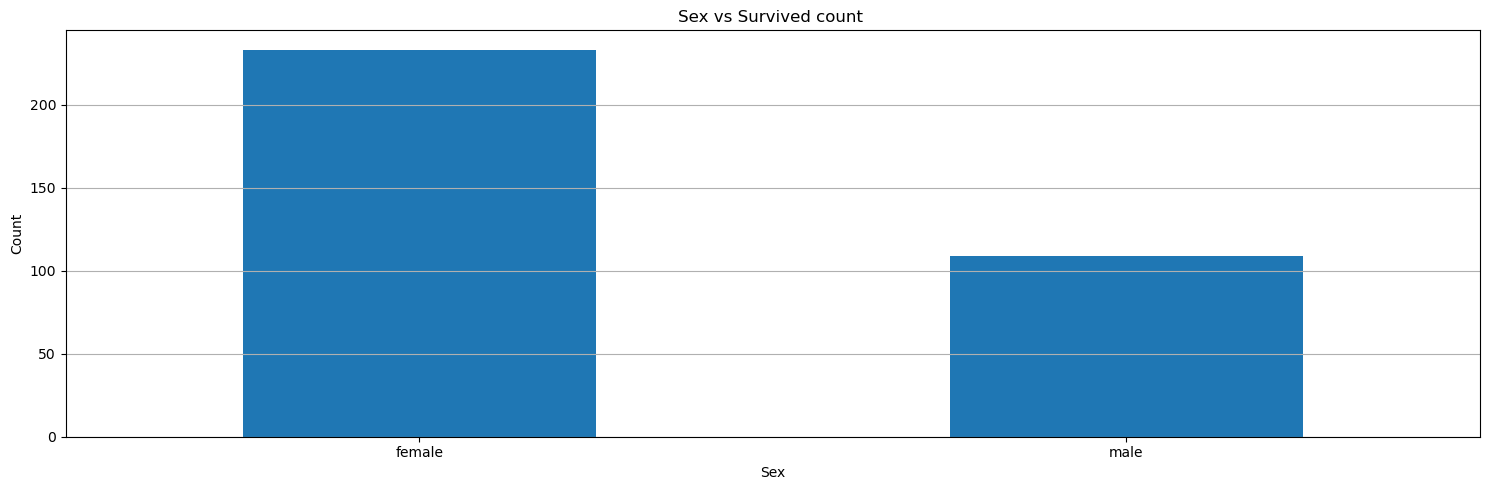

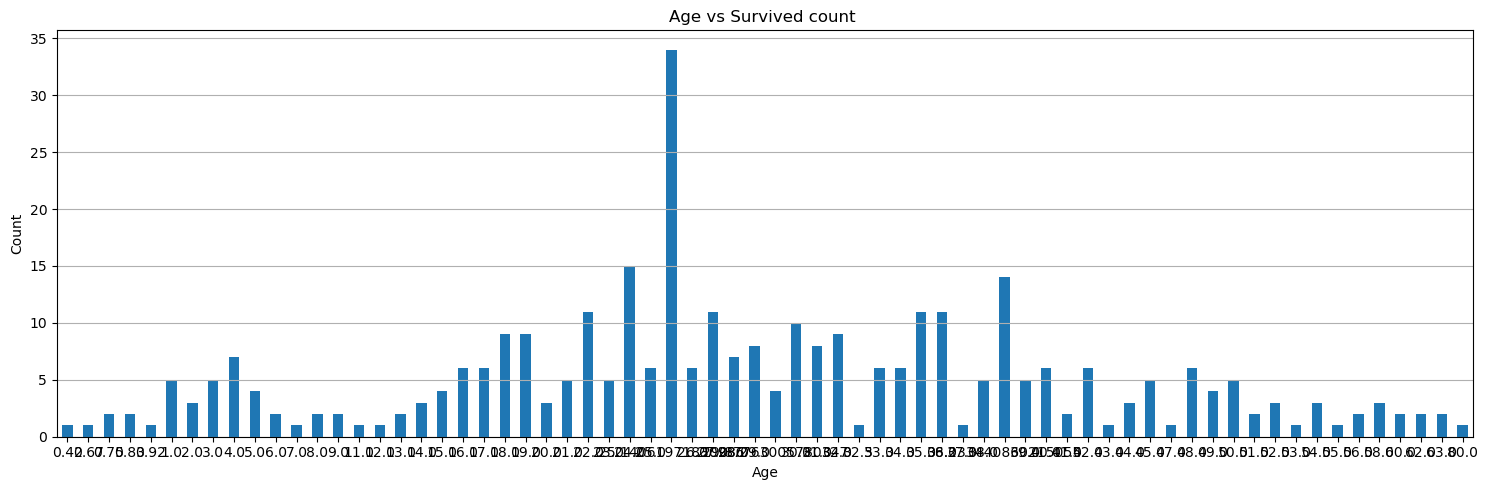

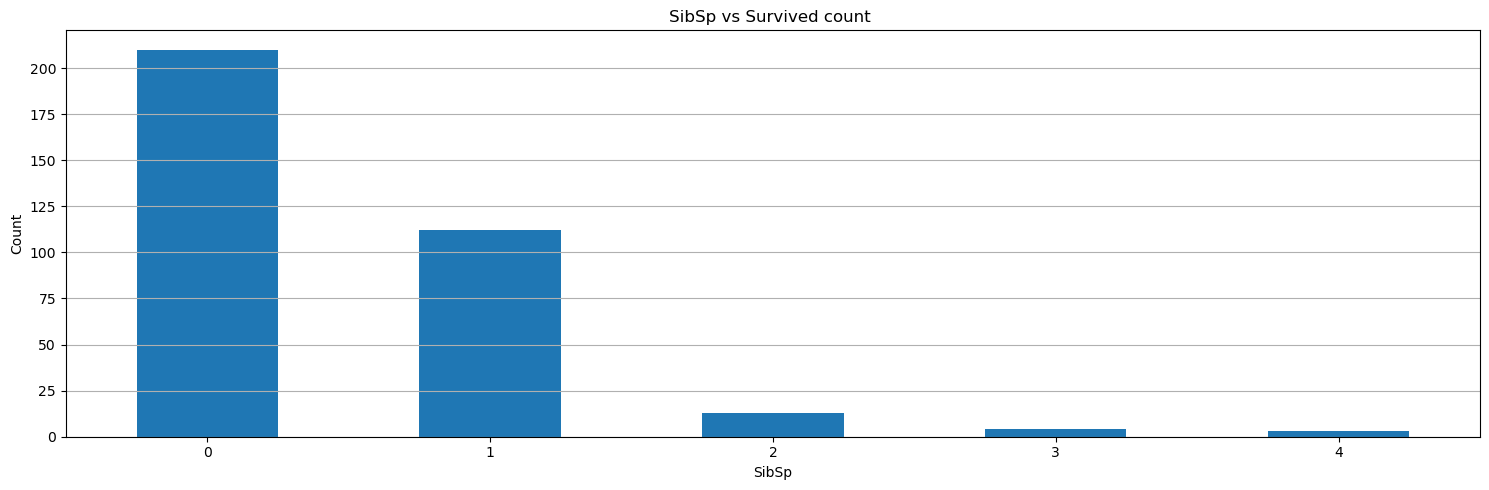

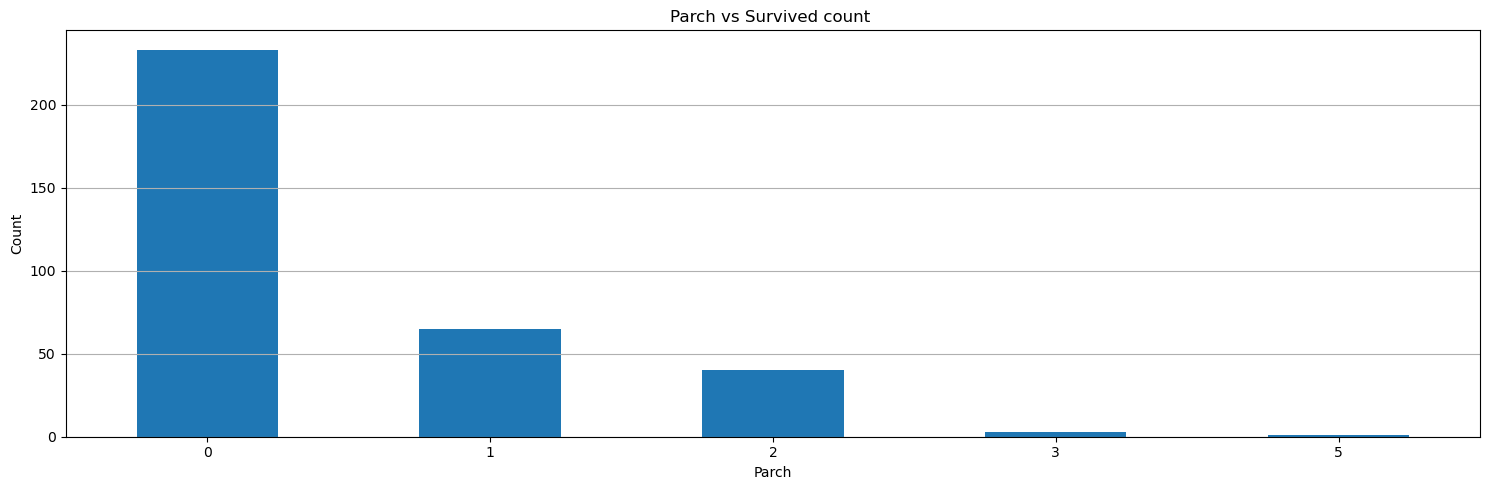

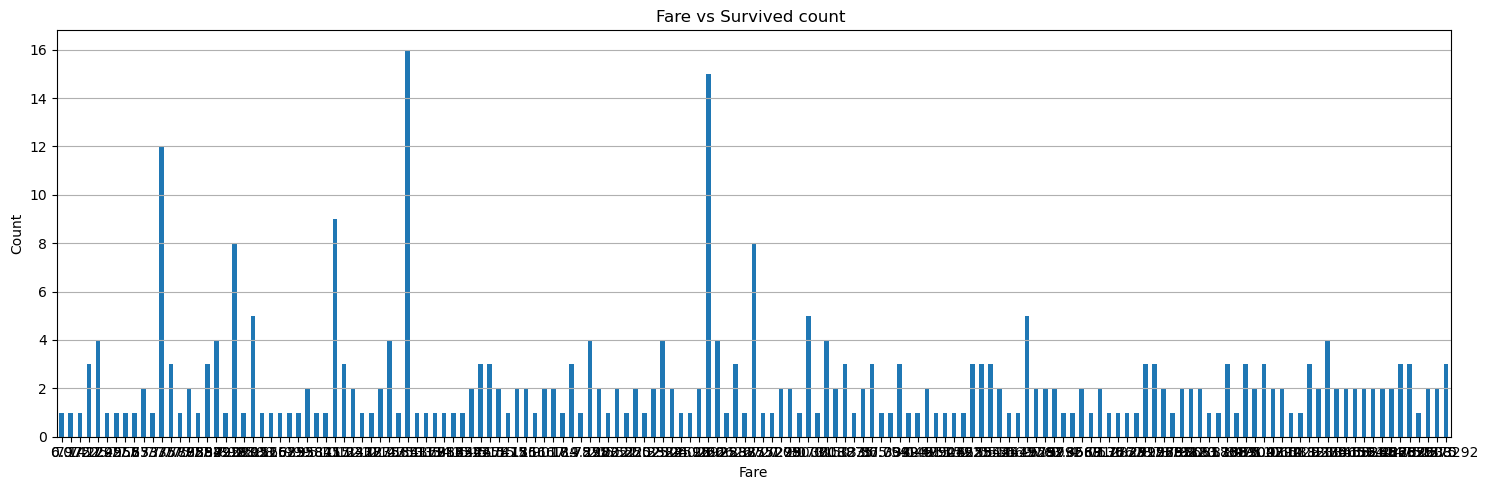

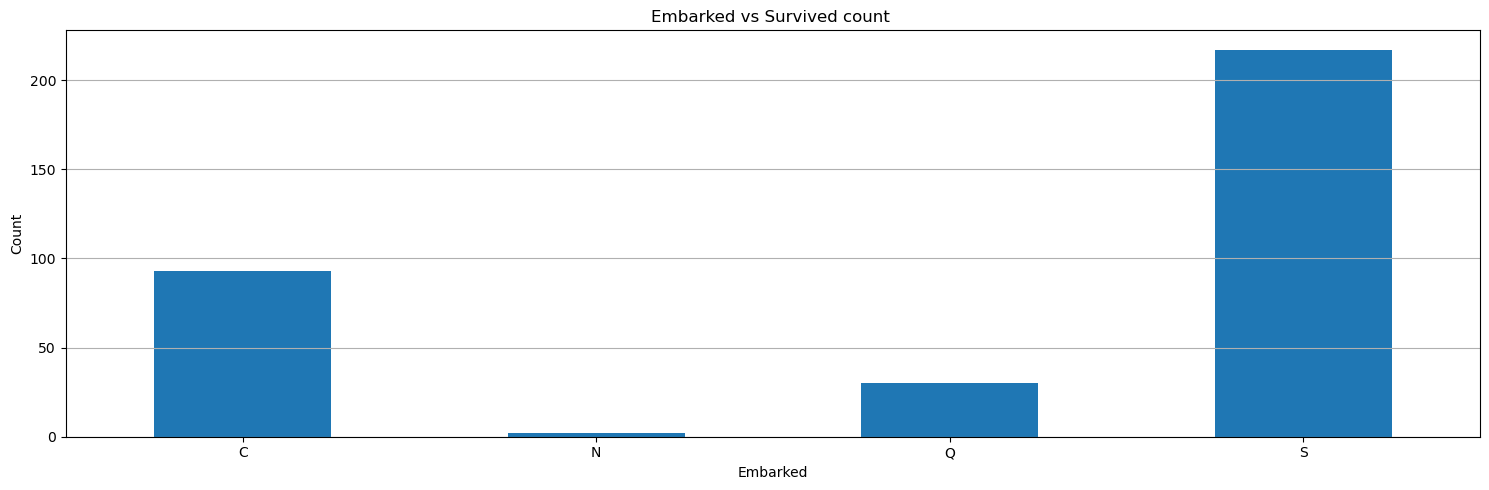

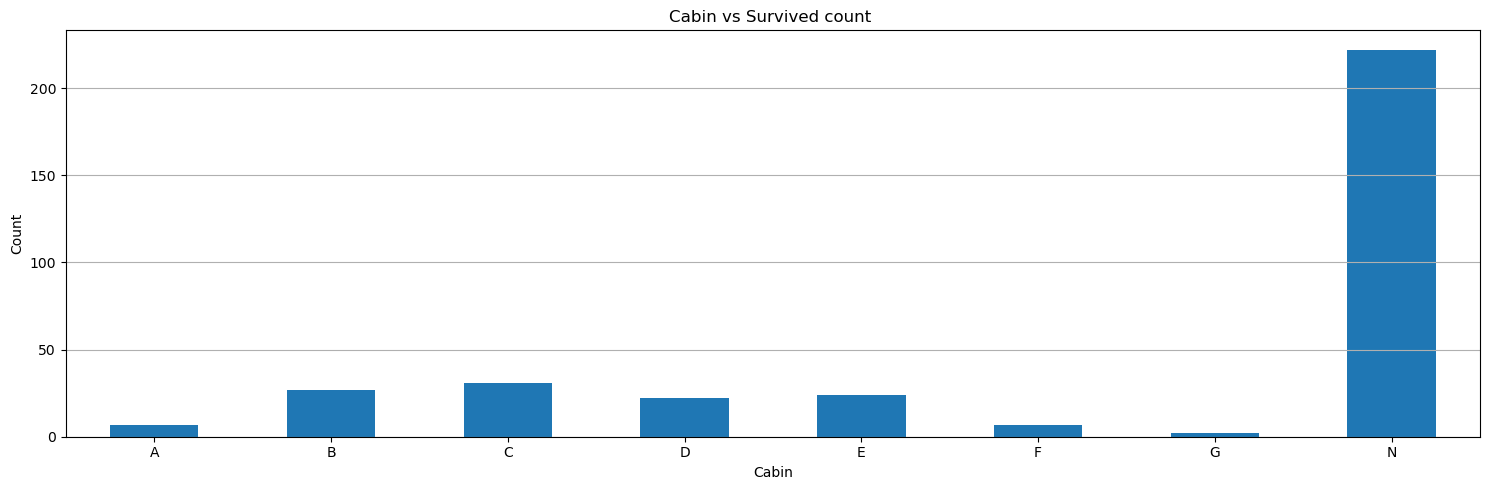

In [194]:
# Check Scatter
target_col = 'Survived'
features = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

for col in features:
    survived_counts = df_train[df_train['Survived'] == 1][col].value_counts().sort_index()

    plt.figure(figsize=(15, 5))
    survived_counts.plot(kind='bar')
    plt.title(f'{col} vs Survived count ')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 2. Preprocessing
If use Tree Moel, Label or Ordinal encoding<br>
If use Linear Model, One-hot encoding

In [195]:
# In this case, will use Label Encoding
# And, 'Age', 'Fare', 'SibSp', 'Parch' will be normalized
from sklearn.preprocessing import LabelEncoder, StandardScaler

encoder = LabelEncoder()

def data_encoding(df):
    df['Sex'] = encoder.fit_transform(df['Sex'])
    df['Cabin'] = encoder.fit_transform(df['Cabin'])
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    return df

df_train = data_encoding(df_train)
df_test = data_encoding(df_test)

scaler = StandardScaler()
df_train[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.fit_transform(df_train[['Age', 'Fare', 'SibSp', 'Parch']])
df_test[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.transform(df_test[['Age', 'Fare', 'SibSp', 'Parch']])


# Select Feature
df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,-0.552360,0.432793,-0.473674,-0.502445,7,3
1,1,0,0.659475,0.432793,-0.473674,0.786845,2,0
2,3,0,-0.249401,-0.474545,-0.473674,-0.488854,7,3
3,1,0,0.432256,0.432793,-0.473674,0.420730,2,3
4,3,1,0.432256,-0.474545,-0.473674,-0.486337,7,3
5,3,1,-0.314491,-0.474545,-0.473674,-0.478116,7,2
6,1,1,1.871311,-0.474545,-0.473674,0.395814,4,3
7,3,1,-2.067155,2.247470,0.767630,-0.224083,7,3
8,3,0,-0.173662,-0.474545,2.008933,-0.424256,7,3
9,2,0,-1.158278,0.432793,-0.473674,-0.042956,7,0


# 3. Model Definition

In [196]:
# Split input and target data
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()
y = df_train['Survived'].to_numpy()

X_pred = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()

# Split Train Data to Train/Validation data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Model List
model_dict = {}

## 3-1. Logistic Regression

In [197]:
def model_LogisticRegression(X, y, cv=2):
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression

    lr = LogisticRegression()

    hp = {
        'penalty' : ['l1', 'l2'],
        'C' : [0.001, 0.01, 0.1, 1, 10, 100],
        'solver' : ['lbfgs', 'liblinear'],
        'max_iter' : [100, 1000, 10000]
    }

    gs = GridSearchCV(lr, param_grid=hp, cv=cv)
    gs.fit(X, y)
    model = gs.best_estimator_
    
    return model

model_dict['LR'] = model_LogisticRegression

## 3-2. SGDClassifier

In [198]:
def model_SGDClassifier(X,y, cv=2):
    from sklearn.linear_model import SGDClassifier
    from sklearn.model_selection import GridSearchCV

    hp = {
        'max_iter' : [10, 100, 1000, 10000]
    }

    sc = SGDClassifier(loss='log_loss', random_state=0)
    gs = GridSearchCV(sc, param_grid=hp, cv=cv)
    gs.fit(X, y)
    model = gs.best_estimator_

    return model

model_dict['SGD'] = model_SGDClassifier

## 3-3. Decsion Tree

In [199]:
def model_DecisionTreeClassifier(X,y, cv=2):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import GridSearchCV

    dt = DecisionTreeClassifier(random_state=0)
    hp = {
        'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
        'max_depth' : range(5, 20, 1),
        'min_samples_split' : range(2, 100, 10)
    }

    gs = GridSearchCV(dt, hp, cv=cv)
    gs.fit(X, y)
    model = gs.best_estimator_
    
    return model

model_dict['DT'] = model_DecisionTreeClassifier

## 3-4. Random Forest

In [200]:
def model_RandomForestClassifier(X,y, cv=2):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    rf = RandomForestClassifier(oob_score=True, random_state=0)

    hp = {
        'min_impurity_decrease' : uniform(0.0001, 0.001),
        'max_depth' : randint(1, 1000),
        'min_samples_split' : randint(2, 25),
        'min_samples_leaf' : randint(1, 25)
    }

    rs = RandomizedSearchCV(rf, hp, n_jobs=-1, n_iter=100, cv=cv, random_state=0)
    rs.fit(X, y)
    model = rs.best_estimator_
    
    return model

model_dict['RF'] = model_RandomForestClassifier

## 3-5. Gradient Boosting

In [201]:
def model_GradientBoostingClassifier(X,y, cv=2):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    gb = GradientBoostingClassifier(learning_rate=0.5, random_state=0)
    hp = {
        'max_depth' : randint(1, 1000),
        'n_estimators': randint(1, 1000),
    }

    rs = RandomizedSearchCV(gb, hp, n_jobs=-1, n_iter=100, cv=cv, random_state=0)
    rs.fit(X_train, y_train)
    model = rs.best_estimator_
    
    return model

model_dict['GB'] = model_GradientBoostingClassifier

## 3-6. Histogram-based Gradient Boosting

In [202]:
def model_HistogramGradientBoosting(X, y, cv=2):
    from sklearn.ensemble import HistGradientBoostingClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    hgb = HistGradientBoostingClassifier(
        learning_rate=0.05, 
        validation_fraction=0.1,
        random_state=0)
    
    hp = {
        'max_iter': randint(300, 1000),
        'max_depth': randint(3, 10),
        'min_samples_leaf': randint(10, 50),
        'l2_regularization': uniform(0.0, 1.0),
    }
    rs = RandomizedSearchCV(hgb, hp, n_jobs=-1, cv=cv, n_iter=50, random_state=0)
    rs.fit(X_train, y_train)
    model = rs.best_estimator_
    return model

model_dict['HGB'] = model_HistogramGradientBoosting

## 3-7. XGBoost

In [203]:
def model_XGBoost(X, y, cv=2):
    from xgboost import XGBClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    xgb = XGBClassifier(tree_method='hist', learning_rate=0.1, random_state=0)
    hp = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10)
    }
    rs = RandomizedSearchCV(xgb, hp, n_jobs=-1, cv=2, n_iter=50, random_state=0)
    rs.fit(X_train, y_train)
    model = rs.best_estimator_
    return model

model_dict['XGB'] = model_XGBoost

# 4. Model Selection

  model  train_accuracy  val_accuracy
0    LR        0.801966      0.815642
1   SGD        0.776685      0.815642
2    DT        0.849719      0.832402
3    RF        0.883427      0.837989
4    GB        0.987360      0.787709
5   HGB        0.905899      0.860335
6   XGB        0.967697      0.871508


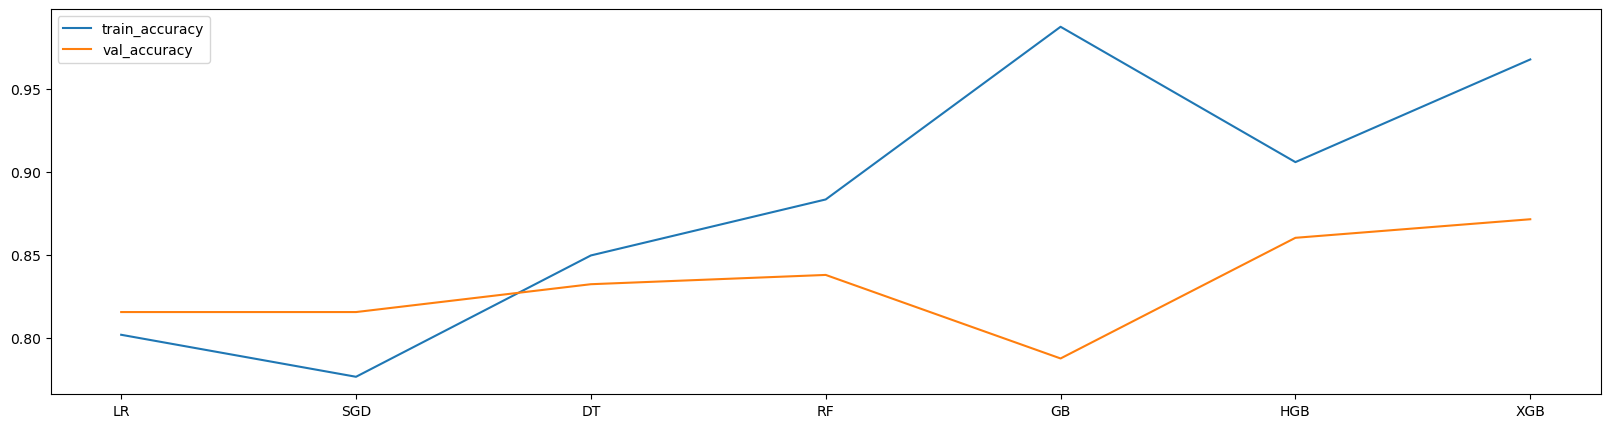

In [210]:
# check model accuracy
# Actually, different models have different tuning methods for hyperparameters, 
# so it's not accurate, but just for reference
df_model_result = pd.DataFrame(columns=['model', 'train_accuracy', 'val_accuracy'])

for name, model_func in model_dict.items():
    model = model_func(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    val_accuracy = model.score(X_val, y_val)
    df_model_result.loc[len(df_model_result)] = {
        'model' : name,
        'train_accuracy' : train_accuracy,
        'val_accuracy' : val_accuracy
    }

print(df_model_result)
plt.figure(figsize=(20, 5))
plt.plot(df_model_result['model'], df_model_result['train_accuracy'])
plt.plot(df_model_result['model'], df_model_result['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# 5. Model Trainning - HGB

# 6. Submission

In [ ]:
final_model = gb
y_pred = final_model.predict(X_pred)

df_sub['Survived'] = y_pred

df_sub.to_csv('./data/submission.csv', index=False)